# Spikey Tutorial

A narrow introduction to Spikey with examples.

Table of Contents
---
1. Installation
2. Pieces of a Spiking Neural Network
3. Creating a Spiking Neural Network
4. Games
5. Training Loops
7. Moving Forward

```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
--------   -------------
| Game |   |  Network  |
--------   -------------
   |            /
   |           /
-----------------
| Training Loop |
-----------------
        |
----------------------
| Aggregate Analysis |
----------------------
    ^       |
    L_______|
```

## Installation

First open a terminal in the root directory of your cloned Spikey repo.

You should see something like,
```bash
.../username/spikey>
```

If not change terminals working directory to the spikey repo via,
```bash
cd <path to your cloned spikey repo>

# eg,
cd /home/user/spikey
```

Install all necessary dependencies,
```bash
pip install -r requirements.txt
```

Then since Spikey is not yet on pypi, install it locally via
```bash
pip install -e .
```

Spikey only needs to be reinstalled if you re-clone the repo or move it.

In [1]:
# After installation, restart this notebook and this import should work.
import spikey

## Pieces of a spiking neural network

Spiking neural networks are complex systems capable of learning in a similar way to the human brain.
They are composed of many unique parts: neurons, synapses, ... all of which are individually simple, 
yet can cooperate to achieve the ability to understand the environment they operate in.
This is an emergent process.

In this simulator we have individual objects for all spiking network parts.
There are multiple pre-built versions of each, but you may template any of them to create your own versions.

Luckily the Network object exists within Spikey to manage all of these parts for you, but we will kick of the tutorial by demoing them individually.
```
Neuron: Standard neuron behavior.
Synapse: Synaptic learning rule implementation.
Weight: Datastructure to generate and manage network topology, connects individual inputs and neurons together.
Input: Neuron without inputs that serve to encode sensory information from the environment.
Readout: Function to translate the network's reaction into an action within the environment.
Rewarder(RL networks only): Determine how much reward the network deserves for its response.
```
```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
           -------------
           |  Network  |
           -------------
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os
from spikey import Key

In [3]:
# Each piece of the network has many parameters that need to be set.
# All parameters and their descriptions are listed in the parts NECESSARY_KEYS.
input_type = spikey.input.StaticMap
input_type.NECESSARY_KEYS

["n_inputs": "[<class 'int'>] Number input neurons, separate from body.",
 "magnitude": "[(<class 'float'>, <class 'int'>)] Multiplier to each 0, 1 spike value.",
 "input_firing_steps": "[<class 'int'>, default=-1] Number of network steps to fire for, -1 if all.",
 "input_pct_inhibitory": "[(<class 'float'>, <class 'int'>), default=0] Pct of inputs that are inhibitory",
 "state_spike_map": "[(<class 'dict'>, <class 'numpy.ndarray'>, <class 'object'>)] dict[tuple]->ndarray[processing_time, n_inputs, dtype=bool] State to fires map.."]

In [4]:
# Keys can be configured by a dictionary to be passed into the constructor
input_config = {
    'n_inputs': 2,
    'magnitude': 1,
    'firing_steps': -1,
    'input_pct_inhibitory': 0,
    'state_spike_map': {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]},
}
input = input_type(**input_config)
input.reset()

In [5]:
# Tell the input about the environment state
input.update(1)

# Input fire according to state
input()

array([0, 1])

In [6]:
neuron_type = spikey.neuron.Neuron
neuron_type.NECESSARY_KEYS

["magnitude": "[(<class 'float'>, <class 'int'>)] Magnitude of spike.",
 "n_neurons": "[<class 'int'>] Number of neurons in the network.",
 "firing_threshold": "[(<class 'float'>, <class 'int'>)] Neuron voltage threshold to fire.",
 "neuron_pct_inhibitory": "[(<class 'float'>, <class 'int'>), default=0] [0, 1] Percentage of inhibitory neurons.",
 "potential_decay": "[(<class 'float'>, <class 'int'>)] [0, 1] Percentage voltage loss on each tick.",
 "prob_rand_fire": "[(<class 'float'>, <class 'int'>), default=0]  [0, 1] Probability each neuron will randomly fire",
 "refractory_period": "[<class 'int'>] Amount of time after spike neuron cannot fire.",
 "resting_mv": "[(<class 'float'>, <class 'int'>), default=0.0] Neuron resting voltage.",
 "spike_delay": "[<class 'int'>, default=0] [0, 10] Units of time after hitting threshold to fire."]

In [7]:
# Each part manages the whole set of such pieces, eg the Neuron part may contain 100+ neurons.
neuron_config = {
    'magnitude': 1.5,
    'n_neurons': 4,
    'neuron_pct_inhibitory': 0.,
    'potential_decay': .25,
    'prob_rand_fire': 0.,
    'refractory_period': 1,
    'resting_mv': 0.,
    'firing_threshold': 2.,
    'spike_delay': 0,
}
neuron = neuron_type(**neuron_config)
neuron.reset()

neuron.potentials

array([0., 0., 0., 0.], dtype=float16)

In [8]:
# Add potentials then see which fire
neuron += np.full(neuron_config['n_neurons'],  10)
fires = neuron()
fires

array([1.5, 1.5, 1.5, 1.5])

In [9]:
# Every piece of this simulator can be inhereted and extended or modified according to the user's needs.
# Each object contains a base template (eg spikey.weight.template.Weight) that defines bare minimum expected functionality.
from spikey.weight.template import Weight

class CustomWeight(Weight):
    NECESSARY_KEYS = Weight.extend_keys([
        Key('matrix', 'np.ma.array[n_inputs+n_neurons, n_neurons] Connections between individual inputs and neurons.', type=np.ndarray)
    ])
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._matrix = np.ma.copy(kwargs['matrix'])
        assert self._matrix.shape == (self._n_inputs+self._n_neurons, self._n_neurons), \
            "Incorrect weight shape!"
        self.clip()

CustomWeight.NECESSARY_KEYS

["n_inputs": "[<class 'int'>] Number input neurons, separate from body.",
 "n_neurons": "[<class 'int'>] Number of neurons in network.",
 "max_weight": "[(<class 'float'>, <class 'int'>)] Max synapse weight.",
 "matrix": "[<class 'numpy.ndarray'>] np.ma.array[n_inputs+n_neurons, n_neurons] Connections between individual inputs and neurons."]

In [10]:
n_inputs = input_config['n_inputs']
n_neurons = neuron_config['n_neurons']
weight_config = {
    "n_inputs": n_inputs,
    "n_neurons": n_neurons,
    "max_weight": 1,
    'matrix': np.ones((n_inputs+n_neurons, n_neurons))
}
weight = CustomWeight(**weight_config)

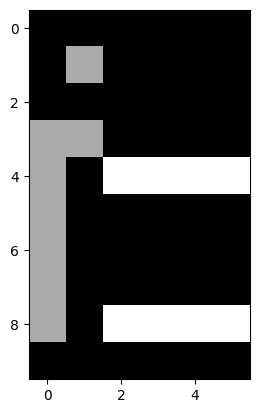

In [11]:
# A bare bones spiking network loop
N_STEP = 10

input.reset()
neuron.reset()

spike_log = np.empty((N_STEP, n_inputs + n_neurons))
for s in range(N_STEP):
    input.update(np.random.randint(4))

    spikes = np.append(input(), neuron())

    neuron += np.matmul(weight.matrix.T, spikes)

    spike_log[s] = spikes

plt.imshow(spike_log, cmap='gray')
plt.show()

## Creating a Spiking Neural Network

Network is a neat interface for the many pieces that actually make up a spiking neural network.
Simply pass it a list of part types with their configurations and it's ready to train.

```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
           -------------
           |  Network  |
           -------------
```

In [12]:
# Similar to individual piece's NECESSARY_KEYS, the Network has NECESSARY_PARTS
network_type = spikey.network.RLNetwork
network_type.NECESSARY_PARTS

["inputs": "[any] snn.input.Input",
 "neurons": "[any] snn.neuron.Neuron",
 "weights": "[any] snn.weight.Weight",
 "synapses": "[any] snn.synapse.Synapse",
 "readout": "[any] snn.readout.Readout",
 "modifiers": "[any, default=None] list of snn.modifier.Modifier",
 "rewarder": "[any] snn.reward.Reward"]

In [13]:
parts = {
    'inputs': spikey.input.StaticMap,
    'neurons': spikey.neuron.Neuron,
    'weights': spikey.weight.Manual,
    'synapses': spikey.synapse.RLSTDP,
    'readout': spikey.readout.NeuronRates,
    'modifiers': None,
    'rewarder': spikey.reward.MatchExpected,
}

network_type.list_keys(**parts)

{
	"n_inputs": "[<class 'int'>] Number input neurons, separate from body.",
	"n_outputs": "[<class 'int'>] Number of output neurons, a subset of body neurons.",
	"n_neurons": "[<class 'int'>] Number of neurons in the network.",
	"processing_time": "[<class 'int'>] Number of network timesteps per game timestep.",
	"magnitude": "[(<class 'float'>, <class 'int'>)] Multiplier to each 0, 1 spike value.",
	"input_firing_steps": "[<class 'int'>, default=-1] Number of network steps to fire for, -1 if all.",
	"input_pct_inhibitory": "[(<class 'float'>, <class 'int'>), default=0] Pct of inputs that are inhibitory",
	"state_spike_map": "[(<class 'dict'>, <class 'numpy.ndarray'>, <class 'object'>)] dict[tuple]->ndarray[processing_time, n_inputs, dtype=bool] State to fires map..",
	"firing_threshold": "[(<class 'float'>, <class 'int'>)] Neuron voltage threshold to fire.",
	"neuron_pct_inhibitory": "[(<class 'float'>, <class 'int'>), default=0] [0, 1] Percentage of inhibitory neurons.",
	"potential_

In [14]:
network_config = {
    "n_inputs": 2,
	"n_neurons": 4,
	"n_outputs": 4,
	"processing_time": 10,

	"magnitude": 1,
	"resting_mv": 0,
	"firing_threshold": 2,
	"spike_delay": 0,
	"refractory_period": 1,
	"potential_decay": .25,
	"prob_rand_fire": 0,
	"neuron_pct_inhibitory": 0,

	"learning_rate": .01,
	"stdp_window": 20,
	"trace_decay": .25,
	"max_weight": 1,
	"matrix": np.random.uniform(size=(6, 4)),
	"inh_weight_mask": None,

	"state_spike_map": type('input_map', (object,), {'__getitem__': lambda s, x: np.array(x)})(),
	"input_pct_inhibitory": 0,

    "n_actions": 0,
	"output_range": [0, 1],

	"expected_value": lambda state: np.sum(state) % 2,
}

network = network_type(**parts, **network_config)

In [15]:
# Alternative constructor approach, more readable when sharing to training loops and meta tools. Network template variables config and template parts have lower(lowest) priority than kwargs.
class network_template(network_type):
    keys = network_config
    parts = parts

network = network_template()

In [16]:
network.reset()

for s in range(10):
    output_rates = network.tick(np.random.randint(2, size=2))

    print(output_rates)

[0.2 0.2 0.1 0.1]
[0.4 0.4 0.4 0.2]
[0.  0.1 0.  0. ]
[0.2 0.2 0.1 0.1]
[0.4 0.4 0.4 0.2]
[0.3 0.5 0.3 0.1]
[0.3 0.4 0.3 0.2]
[0.3 0.5 0.4 0.2]
[0.  0.2 0.3 0. ]
[0.2 0.3 0.2 0.1]


## Games

A game is the framework for how agents can interact with some environment. Spikey contains two classes of games: RL and MetaRL. RL is for training spiking neural networks and MetaRL is for genetic algorithms.

All Spikey games are modelled after OpenAI gym environments, which can be converted to RL or MetaRL objects by the gym wrapper.

It is important to use Spikey's pre-built games or build off of a template to ensure compatability with training loops and meta analysis tools.

```python
game_config = {
    'n_inputs': 2,
    'expected_value': lambda state: np.sum(state) % 2,
}
game = spikey.RL.Logic(**game_config)

state = game.reset()
for _ in range(10):
    action = network.tick(state)

    state, reward, done, info = game.step(action)
    print(state, '\t->', action)
    if done:
        break
```

In [17]:
game_type = spikey.games.Logic
game_type.NECESSARY_KEYS

["expected_value": "[any] func(state) Correct response of logic gate to specific state."]

In [18]:
# Games may have a set of presets in game.PRESETS that set values for each key
game_type.PRESETS

{'AND': {'name': 'AND',
  'expected_value': <function spikey.games.Logic.and_fn(state)>},
 'OR': {'name': 'OR',
  'expected_value': <function spikey.games.Logic.or_fn(state)>},
 'XOR': {'name': 'XOR',
  'expected_value': <function spikey.games.Logic.xor_fn(state)>}}

In [19]:
# Initialization using preset only
game = game_type(preset='XOR')

In [20]:
# Are able to use kwargs similar to network, which take precedent over the preset
game_config = {
    'n_inputs': 2,
    'expected_value': lambda state: np.sum(state) % 2,
}
game = game_type(**game_config)

In [21]:
# An alternative method, hardcoded game_template.config has lower(lowest) priority than presets and kwargs.
class game_template(game_type):
    config = game_config

game = game_template()
_ = game.seed(0)

In [22]:
state = game.reset()
for _ in range(10):
    action = network.tick(state)

    state, reward, done, info = game.step(action)
    print(state, '\t->', action)
    if done:
        break

(False, True) 	-> [0.  0.1 0.  0. ]
(False, True) 	-> [0.2 0.2 0.1 0.1]
(False, False) 	-> [0.3 0.3 0.3 0.1]
(False, True) 	-> [0. 0. 0. 0.]
(True, True) 	-> [0.2 0.2 0.1 0.1]
(True, True) 	-> [0.4 0.4 0.4 0.2]
(False, False) 	-> [0.3 0.5 0.3 0.1]
(True, True) 	-> [0.  0.1 0.1 0.1]
(False, True) 	-> [0.3 0.4 0.3 0.2]
(False, True) 	-> [0.2 0.3 0.3 0.1]


## Training Loops

Spiking neural networks are trained by having them interact with some environment, then giving them feedback based on their performance via some reinforcement or supervision signal.
In practice, the code that facilitates this process is called a training loop.
By the way Spikey is organized, many distinct experiments can be executed with the exact same training loops.
Therefore Spikey provides both pre-built and the ability for users to define their own training loops.

Spikey uses [Ray Train, PyTorch version](https://docs.ray.io/en/latest/train/getting-started.html) for simple and distributed training.
```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
--------   -------------
| Game |   |  Network  |
--------   -------------
   |            /
   |           /
-----------------
| Training Loop |
-----------------
```

In [23]:
from ray.train.torch import TorchTrainer
from ray.air.config import ScalingConfig, RunConfig

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# Using pre-built, distributable training loop
experiment_params = {
    **network_config,
    **parts,
    **game_config,
    "n_episodes": 1,
    "len_episode": 10,
}

def train_func():
    game = game_type(**experiment_params)
    model = network_type(**experiment_params)

    states = []
    actions = []
    for epoch in range(experiment_params["n_episodes"]):
        model.reset()
        state = game.reset()
        state_next = None

        states.append([])
        actions.append([])
        for s in range(experiment_params["len_episode"]):
            action = model.tick(state)
            state_next, _, done, __ = game.step(action)
            reward = model.reward(state, action, state_next)

            states[-1].append(state)
            actions[-1].append(action)

            state = state_next
            if done:
                break

    print("States:", states)
    print("Actions:", actions)

    return {}

trainer = TorchTrainer(
    train_func,
    scaling_config=ScalingConfig(num_workers=1),
    run_config=RunConfig(verbose=0),
)
results = trainer.fit()

(RayTrainWorker pid=19052) States: [[(False, True), (True, False), (False, False), (True, True), (False, True), (True, False), (True, True), (False, False), (False, False), (False, False)]]
(RayTrainWorker pid=19052) Actions: [[array([0.2, 0.2, 0.1, 0.1], dtype=float16), array([0.1, 0.3, 0.3, 0. ], dtype=float16), array([0., 0., 0., 0.], dtype=float16), array([0.3, 0.4, 0.3, 0.2], dtype=float16), array([0.3, 0.3, 0.2, 0.1], dtype=float16), array([0.1, 0.3, 0.4, 0.1], dtype=float16), array([0.4, 0.5, 0.4, 0.2], dtype=float16), array([0., 0., 0., 0.], dtype=float16), array([0., 0., 0., 0.], dtype=float16), array([0., 0., 0., 0.], dtype=float16)]]


(RayTrainWorker pid=19052) 2022-12-11 09:00:48,162	INFO config.py:87 -- Setting up process group for: env:// [rank=0, world_size=1]
2022-12-11 09:00:52,960	ERROR checkpoint_manager.py:327 -- Result dict has no key: training_iteration. checkpoint_score_attr must be set to a key in the result dict. Valid keys are: ['trial_id', 'experiment_id', 'date', 'timestamp', 'pid', 'hostname', 'node_ip', 'done']


Trial TorchTrainer_595d3_00000 completed. Last result: 


In [25]:
# Fully custom training loop
# NOTE: This method not recomended if you intend to use it in any meta analysis tools.
game = game_template()
network = network_template(game=game)

for e in range(experiment_params["n_episodes"]):
    network.reset()
    state = game.reset()

    for s in range(experiment_params["len_episode"]):
        action = network.tick(state)

        state_next, _, done, __ = game.step(action)

        if hasattr(network, 'reward') and callable(getattr(network, 'reward')):
            reward = network.reward(state, action, state_next)

        print(state, '\t->', action)

        state = state_next

        if done:
            break

(True, True) 	-> [0.3 0.4 0.3 0.2]
(False, False) 	-> [0.  0.  0.1 0. ]
(True, False) 	-> [0.  0.2 0.2 0. ]
(True, False) 	-> [0.  0.2 0.2 0. ]
(True, True) 	-> [0.3 0.4 0.4 0.2]
(True, False) 	-> [0.  0.3 0.2 0. ]
(False, False) 	-> [0. 0. 0. 0.]
(False, False) 	-> [0. 0. 0. 0.]
(True, True) 	-> [0.3 0.4 0.3 0.2]
(False, False) 	-> [0.1 0.  0.1 0. ]


## Moving Forward

Along with the core SNN framework and training platform, Spikey contains meta analysis tools(eg genetic algorithm), a small vizualization set and pre-configured experiments in examples/ and `spikey.experiments`.

Compared to deep neural networks, spiking neural networks are much closer to complex, dynamical systems than statistical tools. Interestingly they have the natural ability to reason about temporal information like series of events playing out over time. Internally they are able to encode information not only by the magnitudes of neuron fires but also into firing rates and temporal patterns! These attributes make SNNs ideal models for reinforcement learning, control tasks and more!

Please share any difficulties or suggestions with Spikey or your spiking network related research in our issue tab so that we can help.

Further introduction to SNNs,

* [Paugam-Moisy H., Bohte S.(2012) Computing with Spiking Neuron Networks. In: Rozenberg G., Bäck T., Kok J.N. (eds) Handbook of Natural Computing. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-92910-9_10](https://homepages.cwi.nl/~sbohte/publication/paugam_moisy_bohte_SNNChapter.pdf)

* [A. Grüning, S. Bohté(2014) Spiking Neural Networks: Principles and Challenges. ESAN.](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2014-13.pdf)

* [What is a Spiking Neural Network? Spikey.](https://github.com/SpikeyCNS/spikey#spiking-neural-networks)

Some SNN applications,

* [Michael A. Farries and Adrienne L. Fairhall(2007)
Reinforcement Learning With Modulated Spike Timing–Dependent Synaptic Plasticity.
Journal of Neurophysiology 2007 98:6, 3648-3665.](https://journals.physiology.org/doi/pdf/10.1152/jn.00364.2007)

* [Florian R(2007) Reinforcement Learning Through Modulation of
Spike-Timing-Dependent Synaptic Plasticity. Neural Computation 19(6).
https://doi.org/10.1162/neco.2007.19.6.1468](https://www.florian.io/papers/2007_Florian_Modulated_STDP.pdf)

* [Stephen Chung and Robert Kozma(2020) Reinforcement Learning with Feedback-modulated TD-STDP. arXiv 2008.13044.](https://arxiv.org/abs/2008.13044)